In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.manifold import TSNE

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data

In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Supervised learning

## Model: CNN - VGG

In [4]:
class VGG(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Training

In [8]:
# Training function
def train_supervised(model, trainloader, criterion, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(trainloader, desc=f'Epoch {epoch}')
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        pbar.set_postfix({'Loss': train_loss/(batch_idx+1), 'Acc': 100.*correct/total})

    return train_loss/(batch_idx+1), 100.*correct/total

In [9]:
# Evaluation function
def test_supervised(model, testloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total

In [46]:
# Initialize model, loss, and optimizer
supervised_model = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(supervised_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

In [47]:
# Training loop
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(25):
    train_loss, train_acc = train_supervised(supervised_model, trainloader, criterion, optimizer, epoch)
    test_loss, test_acc = test_supervised(supervised_model, testloader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    scheduler.step()

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

Epoch 0: 100%|██████████| 391/391 [00:22<00:00, 17.58it/s, Loss=1.83, Acc=29.9]


Epoch 0: Train Loss: 1.8316, Train Acc: 29.88%, Test Loss: 1.6842, Test Acc: 36.83%


Epoch 1: 100%|██████████| 391/391 [00:22<00:00, 17.72it/s, Loss=1.43, Acc=46.5]


Epoch 1: Train Loss: 1.4301, Train Acc: 46.50%, Test Loss: 1.3327, Test Acc: 53.27%


Epoch 2: 100%|██████████| 391/391 [00:22<00:00, 17.76it/s, Loss=1.11, Acc=61.7]


Epoch 2: Train Loss: 1.1149, Train Acc: 61.67%, Test Loss: 1.0488, Test Acc: 63.88%


Epoch 3: 100%|██████████| 391/391 [00:22<00:00, 17.62it/s, Loss=0.919, Acc=69.1]


Epoch 3: Train Loss: 0.9185, Train Acc: 69.08%, Test Loss: 1.0110, Test Acc: 67.03%


Epoch 4: 100%|██████████| 391/391 [00:22<00:00, 17.04it/s, Loss=0.8, Acc=73.5]


Epoch 4: Train Loss: 0.8005, Train Acc: 73.52%, Test Loss: 0.8193, Test Acc: 72.16%


Epoch 5: 100%|██████████| 391/391 [00:22<00:00, 17.11it/s, Loss=0.73, Acc=76.2]


Epoch 5: Train Loss: 0.7304, Train Acc: 76.21%, Test Loss: 0.8340, Test Acc: 72.15%


Epoch 6: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s, Loss=0.68, Acc=77.9]


Epoch 6: Train Loss: 0.6805, Train Acc: 77.93%, Test Loss: 0.6714, Test Acc: 77.59%


Epoch 7: 100%|██████████| 391/391 [00:22<00:00, 17.34it/s, Loss=0.638, Acc=79.1]


Epoch 7: Train Loss: 0.6383, Train Acc: 79.12%, Test Loss: 0.8083, Test Acc: 74.40%


Epoch 8: 100%|██████████| 391/391 [00:22<00:00, 17.54it/s, Loss=0.62, Acc=79.9]


Epoch 8: Train Loss: 0.6204, Train Acc: 79.86%, Test Loss: 0.7354, Test Acc: 76.55%


Epoch 9: 100%|██████████| 391/391 [00:22<00:00, 17.37it/s, Loss=0.585, Acc=81]


Epoch 9: Train Loss: 0.5854, Train Acc: 80.96%, Test Loss: 0.9554, Test Acc: 70.56%


Epoch 10: 100%|██████████| 391/391 [00:22<00:00, 17.47it/s, Loss=0.575, Acc=81.3]


Epoch 10: Train Loss: 0.5750, Train Acc: 81.27%, Test Loss: 0.8164, Test Acc: 75.15%


Epoch 11: 100%|██████████| 391/391 [00:22<00:00, 17.30it/s, Loss=0.557, Acc=82.1]


Epoch 11: Train Loss: 0.5570, Train Acc: 82.06%, Test Loss: 0.6354, Test Acc: 80.17%


Epoch 12: 100%|██████████| 391/391 [00:22<00:00, 17.57it/s, Loss=0.548, Acc=82.4]


Epoch 12: Train Loss: 0.5483, Train Acc: 82.36%, Test Loss: 0.7309, Test Acc: 77.33%


Epoch 13: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s, Loss=0.54, Acc=82.7]


Epoch 13: Train Loss: 0.5397, Train Acc: 82.68%, Test Loss: 0.8440, Test Acc: 73.80%


Epoch 14: 100%|██████████| 391/391 [00:22<00:00, 17.41it/s, Loss=0.53, Acc=82.8]


Epoch 14: Train Loss: 0.5299, Train Acc: 82.82%, Test Loss: 0.6242, Test Acc: 80.06%


Epoch 15: 100%|██████████| 391/391 [00:22<00:00, 17.33it/s, Loss=0.52, Acc=83.1]


Epoch 15: Train Loss: 0.5202, Train Acc: 83.09%, Test Loss: 0.6598, Test Acc: 78.63%


Epoch 16: 100%|██████████| 391/391 [00:22<00:00, 17.43it/s, Loss=0.505, Acc=83.5]


Epoch 16: Train Loss: 0.5055, Train Acc: 83.52%, Test Loss: 1.0906, Test Acc: 68.13%


Epoch 17: 100%|██████████| 391/391 [00:22<00:00, 17.04it/s, Loss=0.499, Acc=83.9]


Epoch 17: Train Loss: 0.4989, Train Acc: 83.87%, Test Loss: 0.7291, Test Acc: 77.70%


Epoch 18: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s, Loss=0.507, Acc=83.8]


Epoch 18: Train Loss: 0.5070, Train Acc: 83.78%, Test Loss: 0.5429, Test Acc: 81.98%


Epoch 19: 100%|██████████| 391/391 [00:23<00:00, 16.89it/s, Loss=0.488, Acc=84.3]


Epoch 19: Train Loss: 0.4880, Train Acc: 84.30%, Test Loss: 0.6187, Test Acc: 79.85%


Epoch 20: 100%|██████████| 391/391 [00:23<00:00, 16.90it/s, Loss=0.483, Acc=84.3]


Epoch 20: Train Loss: 0.4834, Train Acc: 84.29%, Test Loss: 0.6316, Test Acc: 78.77%


Epoch 21: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s, Loss=0.484, Acc=84.2]


Epoch 21: Train Loss: 0.4841, Train Acc: 84.17%, Test Loss: 0.5303, Test Acc: 82.59%


Epoch 22: 100%|██████████| 391/391 [00:22<00:00, 17.42it/s, Loss=0.471, Acc=84.9]


Epoch 22: Train Loss: 0.4706, Train Acc: 84.88%, Test Loss: 0.5697, Test Acc: 81.37%


Epoch 23: 100%|██████████| 391/391 [00:22<00:00, 17.42it/s, Loss=0.476, Acc=84.6]


Epoch 23: Train Loss: 0.4757, Train Acc: 84.58%, Test Loss: 0.7139, Test Acc: 77.40%


Epoch 24: 100%|██████████| 391/391 [00:22<00:00, 17.32it/s, Loss=0.466, Acc=85]


Epoch 24: Train Loss: 0.4660, Train Acc: 85.03%, Test Loss: 0.6739, Test Acc: 79.31%


## Visualize embeddings


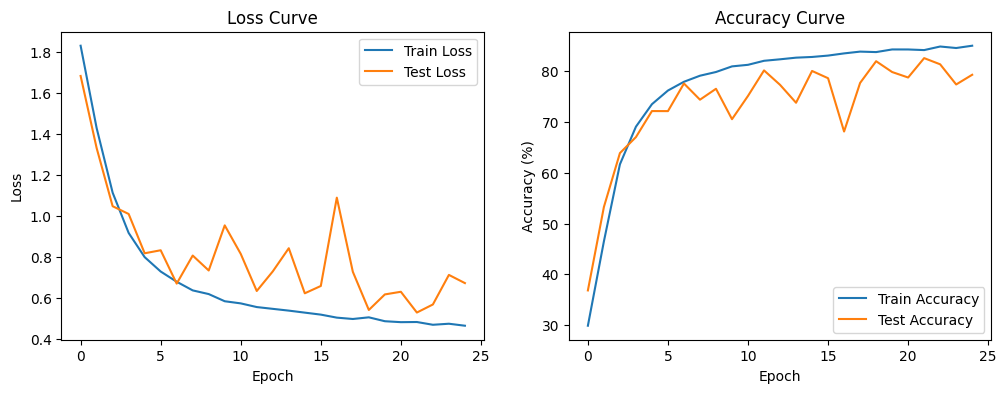

In [48]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
###########################################
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

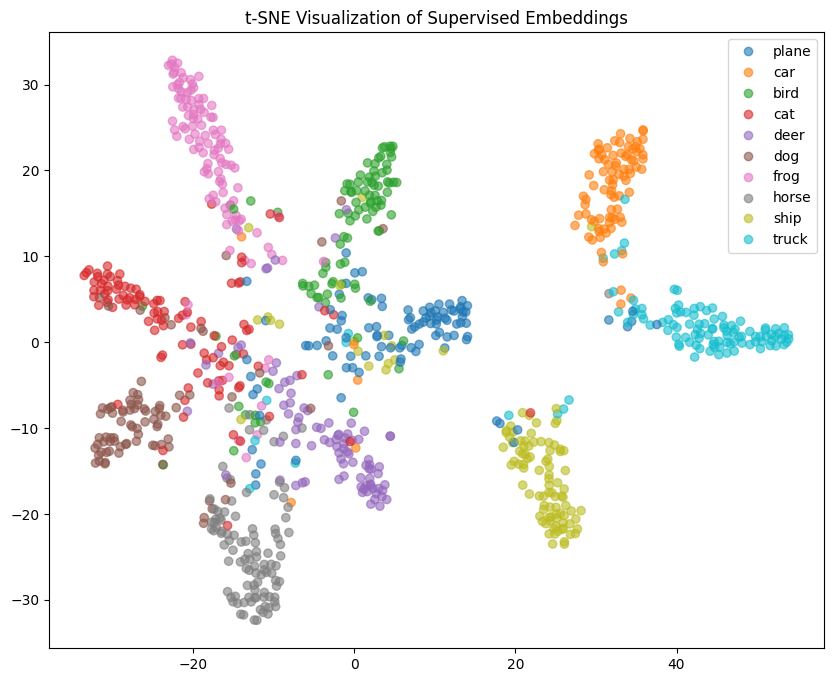

In [49]:
def visualize_embeddings(model, dataloader, num_samples=1000):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            # Get features before the classifier
            x = model.features(inputs)
            x = model.avgpool(x)
            x = torch.flatten(x, 1)

            features.append(x.cpu().numpy())
            labels.append(targets.numpy())

            if len(np.concatenate(features)) >= num_samples:
                break

    features = np.concatenate(features)[:num_samples]
    labels = np.concatenate(labels)[:num_samples]

    # Reduce dimensionality with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.title('t-SNE Visualization of Supervised Embeddings')
    plt.show()

visualize_embeddings(supervised_model, testloader)

# SSL - Contrastive Learning

## Data Augmentation

In [17]:
# Data augmentation for contrastive learning
contrastive_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [18]:
# Create dataset that returns two augmented views
class ContrastiveDataset(torchvision.datasets.CIFAR10):
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        x1 = contrastive_transform(img)
        x2 = contrastive_transform(img)

        return x1, x2, target

contrastive_trainset = ContrastiveDataset(root='./data', train=True, download=True, transform=None)
contrastive_trainloader = torch.utils.data.DataLoader(contrastive_trainset, batch_size=256, shuffle=True, num_workers=2)

## Model

In [19]:
# Define the contrastive learning model (same architecture but without classifier)
class VGGContrastive(nn.Module):
    def __init__(self, projection_dim=128):
        super(VGGContrastive, self).__init__()
        self.encoder = nn.Sequential(
            # Same feature extractor as before
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        z = self.projection(x)
        return F.normalize(z, dim=1)

## Contrastive Loss

In [20]:
# Contrastive loss (NT-Xent)
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)

        # Concatenate positive pairs
        z = torch.cat([z_i, z_j], dim=0)

        # Compute similarity matrix
        sim_matrix = torch.mm(z, z.t()) / self.temperature

        # Create positive mask (diagonals of the two blocks)
        pos_mask = torch.zeros(2*batch_size, 2*batch_size, dtype=torch.bool, device=z.device)
        pos_mask[:batch_size, batch_size:] = torch.eye(batch_size, dtype=torch.bool, device=z.device)
        pos_mask[batch_size:, :batch_size] = torch.eye(batch_size, dtype=torch.bool, device=z.device)

        # Create negative mask (everything except diagonals and positive pairs)
        neg_mask = ~torch.eye(2*batch_size, dtype=torch.bool, device=z.device) & ~pos_mask

        # Compute logits for positive and negative pairs
        pos_logits = sim_matrix[pos_mask].reshape(2*batch_size, 1)
        neg_logits = sim_matrix[neg_mask].reshape(2*batch_size, -1)

        # Compute log probability
        logits = torch.cat([pos_logits, neg_logits], dim=1)
        log_prob = F.log_softmax(logits, dim=1)

        # Loss is negative mean log-likelihood of positive pairs
        loss = -log_prob[:, 0].mean()

        return loss

## Training

In [21]:
# Training function for contrastive learning
def train_contrastive(model, trainloader, criterion, optimizer, epoch):
    model.train()
    train_loss = 0

    pbar = tqdm(trainloader, desc=f'Contrastive Epoch {epoch}')
    for batch_idx, (x1, x2, _) in enumerate(pbar):
        x1, x2 = x1.to(device), x2.to(device)

        optimizer.zero_grad()
        z1 = model(x1)
        z2 = model(x2)
        loss = criterion(z1, z2)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pbar.set_postfix({'Loss': train_loss/(batch_idx+1)})

    return train_loss/(batch_idx+1)

In [22]:
# Initialize contrastive model and optimizer
contrastive_model = VGGContrastive().to(device)
contrastive_criterion = ContrastiveLoss(temperature=0.5)
contrastive_optimizer = optim.Adam(contrastive_model.parameters(), lr=3e-4)

In [26]:
# Training loop for contrastive learning
contrastive_losses = []

for epoch in range(25):
    loss = train_contrastive(contrastive_model, contrastive_trainloader, contrastive_criterion, contrastive_optimizer, epoch)
    contrastive_losses.append(loss)
    print(f'Contrastive Epoch {epoch}: Loss: {loss:.4f}')

Contrastive Epoch 0: 100%|██████████| 196/196 [01:19<00:00,  2.46it/s, Loss=5.26]


Contrastive Epoch 0: Loss: 5.2620


Contrastive Epoch 1: 100%|██████████| 196/196 [01:19<00:00,  2.45it/s, Loss=5.01]


Contrastive Epoch 1: Loss: 5.0121


Contrastive Epoch 2: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, Loss=4.92]


Contrastive Epoch 2: Loss: 4.9202


Contrastive Epoch 3: 100%|██████████| 196/196 [01:19<00:00,  2.47it/s, Loss=4.87]


Contrastive Epoch 3: Loss: 4.8704


Contrastive Epoch 4: 100%|██████████| 196/196 [01:20<00:00,  2.45it/s, Loss=4.83]


Contrastive Epoch 4: Loss: 4.8350


Contrastive Epoch 5: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, Loss=4.81]


Contrastive Epoch 5: Loss: 4.8061


Contrastive Epoch 6: 100%|██████████| 196/196 [01:19<00:00,  2.47it/s, Loss=4.79]


Contrastive Epoch 6: Loss: 4.7864


Contrastive Epoch 7: 100%|██████████| 196/196 [01:19<00:00,  2.47it/s, Loss=4.77]


Contrastive Epoch 7: Loss: 4.7719


Contrastive Epoch 8: 100%|██████████| 196/196 [01:19<00:00,  2.48it/s, Loss=4.75]


Contrastive Epoch 8: Loss: 4.7543


Contrastive Epoch 9: 100%|██████████| 196/196 [01:18<00:00,  2.50it/s, Loss=4.74]


Contrastive Epoch 9: Loss: 4.7395


Contrastive Epoch 10: 100%|██████████| 196/196 [01:19<00:00,  2.47it/s, Loss=4.73]


Contrastive Epoch 10: Loss: 4.7291


Contrastive Epoch 11: 100%|██████████| 196/196 [01:19<00:00,  2.45it/s, Loss=4.72]


Contrastive Epoch 11: Loss: 4.7201


Contrastive Epoch 12: 100%|██████████| 196/196 [01:18<00:00,  2.50it/s, Loss=4.71]


Contrastive Epoch 12: Loss: 4.7138


Contrastive Epoch 13: 100%|██████████| 196/196 [01:18<00:00,  2.49it/s, Loss=4.71]


Contrastive Epoch 13: Loss: 4.7070


Contrastive Epoch 14: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, Loss=4.7]


Contrastive Epoch 14: Loss: 4.6981


Contrastive Epoch 15: 100%|██████████| 196/196 [01:19<00:00,  2.47it/s, Loss=4.69]


Contrastive Epoch 15: Loss: 4.6924


Contrastive Epoch 16: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s, Loss=4.69]


Contrastive Epoch 16: Loss: 4.6872


Contrastive Epoch 17: 100%|██████████| 196/196 [01:23<00:00,  2.34it/s, Loss=4.68]


Contrastive Epoch 17: Loss: 4.6849


Contrastive Epoch 18: 100%|██████████| 196/196 [01:19<00:00,  2.48it/s, Loss=4.68]


Contrastive Epoch 18: Loss: 4.6810


Contrastive Epoch 19: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s, Loss=4.67]


Contrastive Epoch 19: Loss: 4.6739


Contrastive Epoch 20: 100%|██████████| 196/196 [01:19<00:00,  2.46it/s, Loss=4.67]


Contrastive Epoch 20: Loss: 4.6701


Contrastive Epoch 21: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, Loss=4.67]


Contrastive Epoch 21: Loss: 4.6680


Contrastive Epoch 22: 100%|██████████| 196/196 [01:19<00:00,  2.46it/s, Loss=4.66]


Contrastive Epoch 22: Loss: 4.6621


Contrastive Epoch 23: 100%|██████████| 196/196 [01:19<00:00,  2.48it/s, Loss=4.66]


Contrastive Epoch 23: Loss: 4.6606


Contrastive Epoch 24: 100%|██████████| 196/196 [01:20<00:00,  2.45it/s, Loss=4.66]

Contrastive Epoch 24: Loss: 4.6566


## Visualize

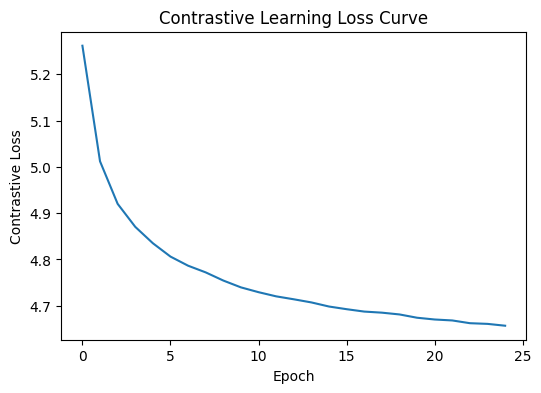

In [27]:
# Plot contrastive learning loss
plt.figure(figsize=(6, 4))
plt.plot(contrastive_losses)
plt.xlabel('Epoch')
plt.ylabel('Contrastive Loss')
plt.title('Contrastive Learning Loss Curve')
plt.show()
# Very Smooth!!

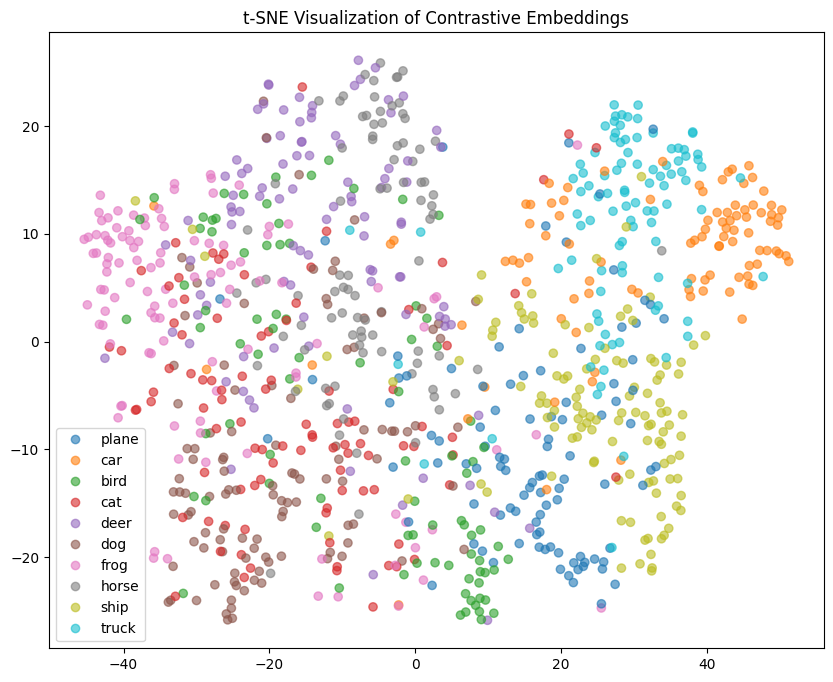

In [28]:
# Visualize contrastive embeddings
def visualize_contrastive_embeddings(model, dataloader, num_samples=1000):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for i, (inputs, _, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            # Get features from the encoder (before projection head)
            x = model.encoder(inputs)
            x = model.avgpool(x)
            x = torch.flatten(x, 1)

            features.append(x.cpu().numpy())
            labels.append(targets.numpy())

            if len(np.concatenate(features)) >= num_samples:
                break

    features = np.concatenate(features)[:num_samples]
    labels = np.concatenate(labels)[:num_samples]

    # Reduce dimensionality with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.title('t-SNE Visualization of Contrastive Embeddings')
    plt.show()

visualize_contrastive_embeddings(contrastive_model, contrastive_trainloader)
# Not well cluster but have a good representation

## Evaluate contrastive model with linear probing (Transfer to CLS task)

In [42]:
def linear_probe_evaluation(contrastive_model, trainloader, testloader, num_classes=10, epochs=25):
    # Freeze the encoder
    for param in contrastive_model.parameters():
        param.requires_grad = False

    # Add linear classifier
    linear_classifier = nn.Linear(512, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(linear_classifier.parameters(), lr=1e-3)

    # Training loop
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        # Train
        linear_classifier.train()
        correct = 0
        total = 0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            with torch.no_grad():
                features = contrastive_model.encoder(inputs)
                features = contrastive_model.avgpool(features)
                features = torch.flatten(features, 1)

            outputs = linear_classifier(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100. * correct / total
        train_accs.append(train_acc)

        # Test
        linear_classifier.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)

                features = contrastive_model.encoder(inputs)
                features = contrastive_model.avgpool(features)
                features = torch.flatten(features, 1)

                outputs = linear_classifier(features)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_acc = 100. * correct / total
        test_accs.append(test_acc)

        print(f'Linear Probe Epoch {epoch}: Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

    # Plot linear probe accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Linear Probe Accuracy')
    plt.show()

    return test_accs[-1]

In [43]:
# Create dataloaders for linear probing
probe_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
probe_trainloader = torch.utils.data.DataLoader(probe_trainset, batch_size=128, shuffle=True, num_workers=2)

probe_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
probe_testloader = torch.utils.data.DataLoader(probe_testset, batch_size=100, shuffle=False, num_workers=2)

Linear Probe Epoch 0: Train Acc: 65.70%, Test Acc: 69.25%
Linear Probe Epoch 1: Train Acc: 68.37%, Test Acc: 70.50%
Linear Probe Epoch 2: Train Acc: 69.05%, Test Acc: 70.09%
Linear Probe Epoch 3: Train Acc: 69.57%, Test Acc: 70.86%
Linear Probe Epoch 4: Train Acc: 69.79%, Test Acc: 71.80%
Linear Probe Epoch 5: Train Acc: 70.19%, Test Acc: 71.15%
Linear Probe Epoch 6: Train Acc: 70.23%, Test Acc: 71.55%
Linear Probe Epoch 7: Train Acc: 70.40%, Test Acc: 71.47%
Linear Probe Epoch 8: Train Acc: 70.55%, Test Acc: 72.43%
Linear Probe Epoch 9: Train Acc: 70.69%, Test Acc: 71.72%
Linear Probe Epoch 10: Train Acc: 70.72%, Test Acc: 71.79%
Linear Probe Epoch 11: Train Acc: 70.95%, Test Acc: 72.37%
Linear Probe Epoch 12: Train Acc: 70.86%, Test Acc: 72.11%
Linear Probe Epoch 13: Train Acc: 71.07%, Test Acc: 72.08%
Linear Probe Epoch 14: Train Acc: 71.39%, Test Acc: 71.78%
Linear Probe Epoch 15: Train Acc: 71.23%, Test Acc: 72.30%
Linear Probe Epoch 16: Train Acc: 71.58%, Test Acc: 71.75%
Linear 

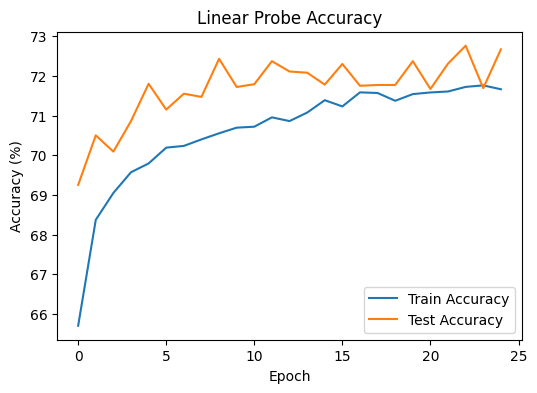

Final linear probe accuracy: 72.67%


In [44]:
# Run linear probe evaluation
final_acc = linear_probe_evaluation(contrastive_model, probe_trainloader, probe_testloader)
print(f'Final linear probe accuracy: {final_acc:.2f}%')

In [45]:
# Compare supervised and contrastive learning
print("\nComparison of Approaches:")
print(f"Supervised Learning Final Test Accuracy: {test_accs[-1]:.2f}%")
print(f"Contrastive Learning + Linear Probe Final Test Accuracy: {final_acc:.2f}%")


Comparison of Approaches:
Supervised Learning Final Test Accuracy: 91.42%
Contrastive Learning + Linear Probe Final Test Accuracy: 72.67%
